# Hazardous Materials

The movement of hazardous materials (hazmat) within UK ports is of particular interest. There are two fields within the CERS database that specify whether a ship enters and leaves a port carrying hazardous materials. This data was used to identify ports where a large proportion of ships either load or unload all or some of their hazmat cargo. 

In [1]:
# base libraries
import numpy as np
import pandas as pd
import datetime
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import branca

In [2]:
# set variable from config file
config_path = os.path.abspath('..')

with open(config_path + '/config.json', 'r') as f:
    config = json.load(f)

cers_path = config['DEFAULT']['cers_path']
cers_filename = config['DEFAULT']['cers_filename']
port_filename = config['DEFAULT']['port_filename']

In [3]:
# import in CERS and ports data
cers = pd.read_csv(cers_path+cers_filename,header = 0,delimiter = ',')
cers['ETA'] = pd.to_datetime(cers["ETA"])
cers['ETA_date'] = cers['ETA'].dt.date
cers.drop_duplicates(keep = 'last',inplace = True)

ports = pd.read_csv(cers_path+port_filename,header = 0,delimiter = ',')

In [4]:
# add the previous and future ports
cers = cers.merge(ports[['LOCODE','Name']], how = 'left', left_on = 'POC_LOCODE', right_on = 'LOCODE')
cers.drop('LOCODE',axis = 1, inplace=True)
cers.rename(columns={'Name':'POC_name'},inplace=True)

cers = cers.merge(ports[['LOCODE','Name']], how = 'left', left_on = 'next_port_LOCODE', right_on = 'LOCODE')
cers.drop('LOCODE',axis = 1, inplace=True)
cers.rename(columns={'Name':'next_port_name'},inplace=True)

cers = cers.merge(ports[['LOCODE','Name']], how = 'left', left_on = 'last_port_LOCODE', right_on = 'LOCODE')
cers.drop('LOCODE',axis = 1, inplace=True)
cers.rename(columns={'Name':'last_port_name'},inplace=True)

### Movement of hazardous materials

In [5]:
# get the inbound and outbound proportion of voyages carrying hazardous materials
in_haz = cers.groupby(['POC_name','in_hazmat'], as_index= False)['voyage_id'].count()
out_haz = cers.groupby(['POC_name','out_hazmat'], as_index= False)['voyage_id'].count()

in_haz['hazmat_dir'] = 'In'
out_haz['hazmat_dir'] = 'Out'

in_haz.rename(columns={'in_hazmat':'hazmat'},inplace=True)
out_haz.rename(columns={'out_hazmat':'hazmat'},inplace=True)

haz = in_haz.append(out_haz)

total_voyages = haz.groupby(['POC_name','hazmat_dir'], as_index= False)['voyage_id'].sum()
total_voyages.rename(columns = {'voyage_id':'total_voyages'}, inplace=True)

haz = haz.merge(total_voyages, how = 'inner', on = ['POC_name','hazmat_dir'])
haz['hazmat_perc'] = haz['voyage_id'] / haz['total_voyages']

In [6]:
belfast = haz[haz.POC_name == 'Belfast']
belfast = belfast.set_index(['hazmat'])
holyhead = haz[haz.POC_name == 'Holyhead']
holyhead = holyhead.set_index(['hazmat'])
hull = haz[haz.POC_name == 'Hull']
hull = hull.set_index(['hazmat'])

In the majority of cases, there are no significant differences between the proportions of ships entering and leaving a port carrying hazmat. However, in a few cases a difference is noted. The charts below show that in Belfast 28% of ships enter port carrying hazmat and 48% leave carrying it, for Holyhead these figures are 25% and 80% respectively, this suggests that both ports send hazmat to other ports. Conversely, 37% of ships entering the port of Hull carry hazmat whilst only 31% leave Hull carrying it, suggesting that Hull accepts hazmat from other ports.

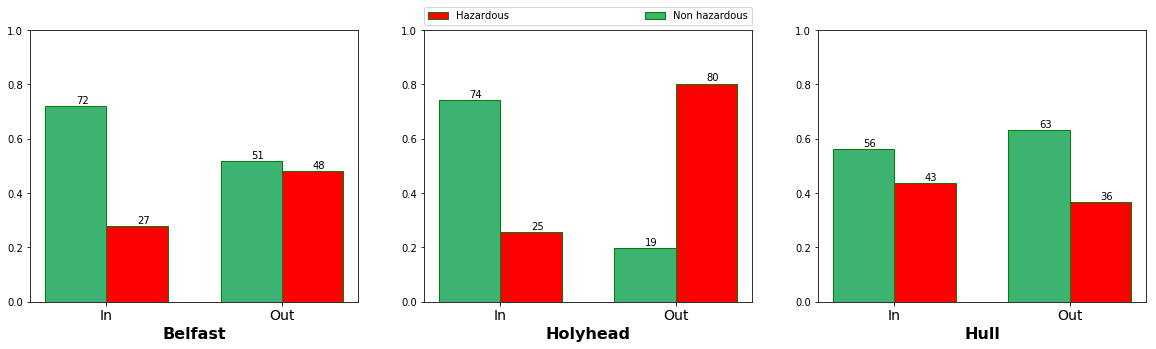

In [7]:
plt.figure(figsize=(20,5))
plt.figure(1)

ind = np.arange(2)
width = 0.35
text_pos = [0,0+width,1,1+width]

plt.subplot(131)
p1 = plt.bar(ind + width, list(belfast.loc['Yes','hazmat_perc']), width, color = 'red', edgecolor = 'green', 
             linewidth=1,label='Hazardous')
p2 = plt.bar(ind, list(belfast.loc['No','hazmat_perc']), width, color = 'mediumseagreen', edgecolor = 'green', 
             linewidth=1,label='Non hazardous')

plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(('In','Out'), fontsize=14)
plt.xlabel('Belfast',fontsize=16, weight='bold')
plt.ylim(0, 1)

for i, n in enumerate(list(belfast.loc[:,'hazmat_perc'])):
    plt.gca().text(text_pos[i], n+0.01, int(n*100)) # (x,y,value)

plt.subplot(132)
p1 = plt.bar(ind + width, list(holyhead.loc['Yes','hazmat_perc']), width, color = 'red', edgecolor = 'green', 
             linewidth=1,label='Hazardous')
p2 = plt.bar(ind, list(holyhead.loc['No','hazmat_perc']), width, color = 'mediumseagreen', edgecolor = 'green', 
             linewidth=1,label='Non hazardous')

plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(('In','Out'), fontsize=14)
plt.xlabel('Holyhead',fontsize=16, weight='bold')
plt.ylim(0, 1)

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

for i, n in enumerate(list(holyhead.loc[:,'hazmat_perc'])):
    plt.gca().text(text_pos[i], n+0.01, int(n*100)) # (x,y,value)
    
plt.subplot(133)
p1 = plt.bar(ind + width, list(hull.loc['Yes','hazmat_perc']), width, color = 'red', edgecolor = 'green', linewidth=1)
p2 = plt.bar(ind, list(hull.loc['No','hazmat_perc']), width, color = 'mediumseagreen', edgecolor = 'green', linewidth=1)

plt.gca().set_xticks(ind + width / 2)
plt.gca().set_xticklabels(('In','Out'), fontsize=14)
plt.xlabel('Hull',fontsize=16, weight='bold')
plt.ylim(0, 1)

for i, n in enumerate(list(hull.loc[:,'hazmat_perc'])):
    plt.gca().text(text_pos[i], n+0.01, int(n*100)) # (x,y,value)

### Destination of hazardous material

In [8]:
destination = cers[(cers.POC_name=='Belfast')|(cers.POC_name=='Holyhead')]
destination = destination[destination.out_hazmat=='Yes']

In [9]:
port_lookup = {'ZZUKN':'Unknown Int','GBGRK':'Greenock','NLRTM':'Rotterdam','NLRTM':'Antwerp','DEHAM':'Hamburg',
               'DEBRV':'Bremerhaven','BEANR':'Amsterdam','USNYC':'New York','QARLF':'Ras Laffen','NLMOE':'Moerdijk',
               'FRLEH':'Le Havre','IEDUB':'Dublin','IEDFT':'Dublin ferryport','IEWHI':'Whitegate','SEOXE':'Oxelosund',
               'AOLAD':'Luanda','LVRIX':'Riga','RUMMK':'Murmansk','BEZEE':'Zeebruggee','FIHEL':'Helsinki'}

destination['next_port_name' ] = destination.apply(lambda row: (row['next_port_LOCODE'] if pd.isnull(row['next_port_name']) else row['next_port_name']),axis=1)
destination['next_port_name' ] = destination['next_port_name'].replace(port_lookup)

In [10]:
destination = destination.groupby(['POC_name','next_port_name'])['voyage_id'].count()

Exploring these differences further, CERS data can be used to understand where the hazmat leaving Belfast and Holyhead goes to and where the hazmat unloaded at Hull comes from. In the case of Belfast the majority travels to Birkenhead, Hesham and Loch Ryan ports. In the case of Holyhead, almost all travels to the ports of Dublin. 

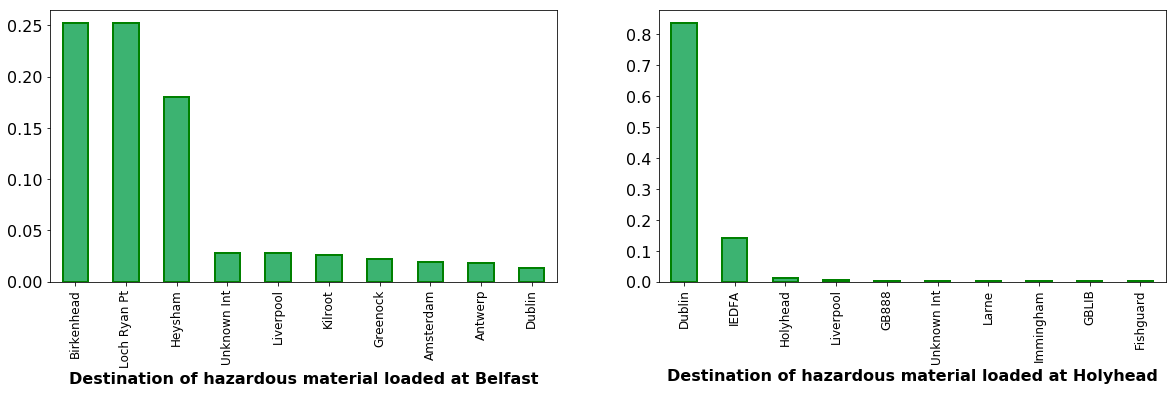

In [11]:
plt.figure(figsize=(20,5))

plt.subplot(121)
belfast = destination['Belfast']
belfast = belfast/belfast.sum()
belfast = belfast.sort_values(ascending=False)
belfast.iloc[:10].plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=2)
plt.xlabel('Destination of hazardous material loaded at Belfast',fontsize=16, weight ='bold')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=16)

plt.subplot(122)
holyhead = destination['Holyhead']
holyhead = holyhead/holyhead.sum()
holyhead = holyhead.sort_values(ascending=False)
holyhead.iloc[:10].plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=2)
plt.xlabel('Destination of hazardous material loaded at Holyhead',fontsize=16, weight ='bold')
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=16)

plt.show()

### Source of hazardous material

In [13]:
source_hull = cers[cers.POC_name=='Hull']
source_hull = source_hull[source_hull.in_hazmat=='Yes']

source_hull['next_port_name' ] = source_hull.apply(lambda row: (row['next_port_LOCODE'] if pd.isnull(row['next_port_name']) else row['next_port_name']),axis=1)
source_hull['next_port_name' ] = source_hull['next_port_name'].replace(port_lookup)

source_hull = source_hull.groupby(['last_port_name'])['voyage_id'].count()

Turning to imported hazardous material and the port of Hull; large proportions are imported from ports outside the UK specifically Rotterdam, Antwerp, Oxelosund in Sweden and Luanda in Angola.

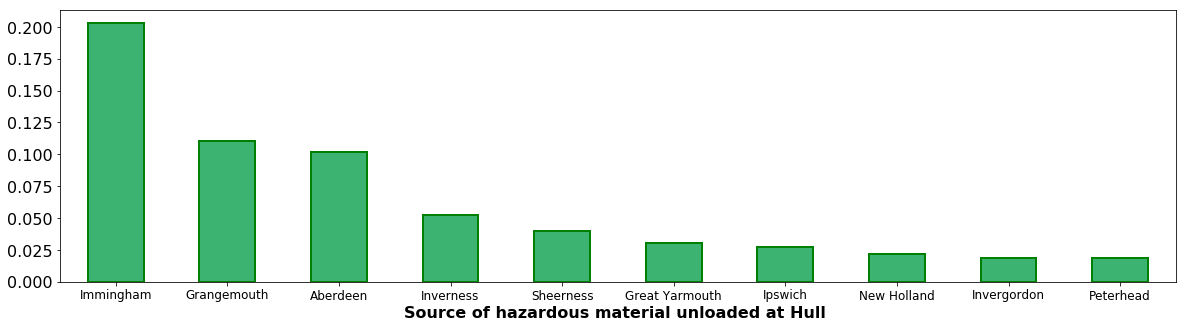

In [14]:
plt.figure(figsize=(20,5))
source_hull = source_hull/source_hull.sum()
source_hull = source_hull.sort_values(ascending=False)
source_hull.iloc[:10].plot(kind='bar', color = 'mediumseagreen', edgecolor = 'green', linewidth=2)
plt.xlabel('Source of hazardous material unloaded at Hull ',fontsize=16, weight ='bold')
plt.xticks(fontsize=12,rotation=0)
plt.yticks(fontsize=16)
plt.show()